In [1]:
import torch
import libs.angular_spectrum as AS
import libs.forward_model as fm
import libs.visualizer as vs
from skimage.metrics import structural_similarity as ssim

### Verification

***Comparing the vector model results with the results obtained from scalar mode***

Sucessfully Initialized Point Spread Function...!!!


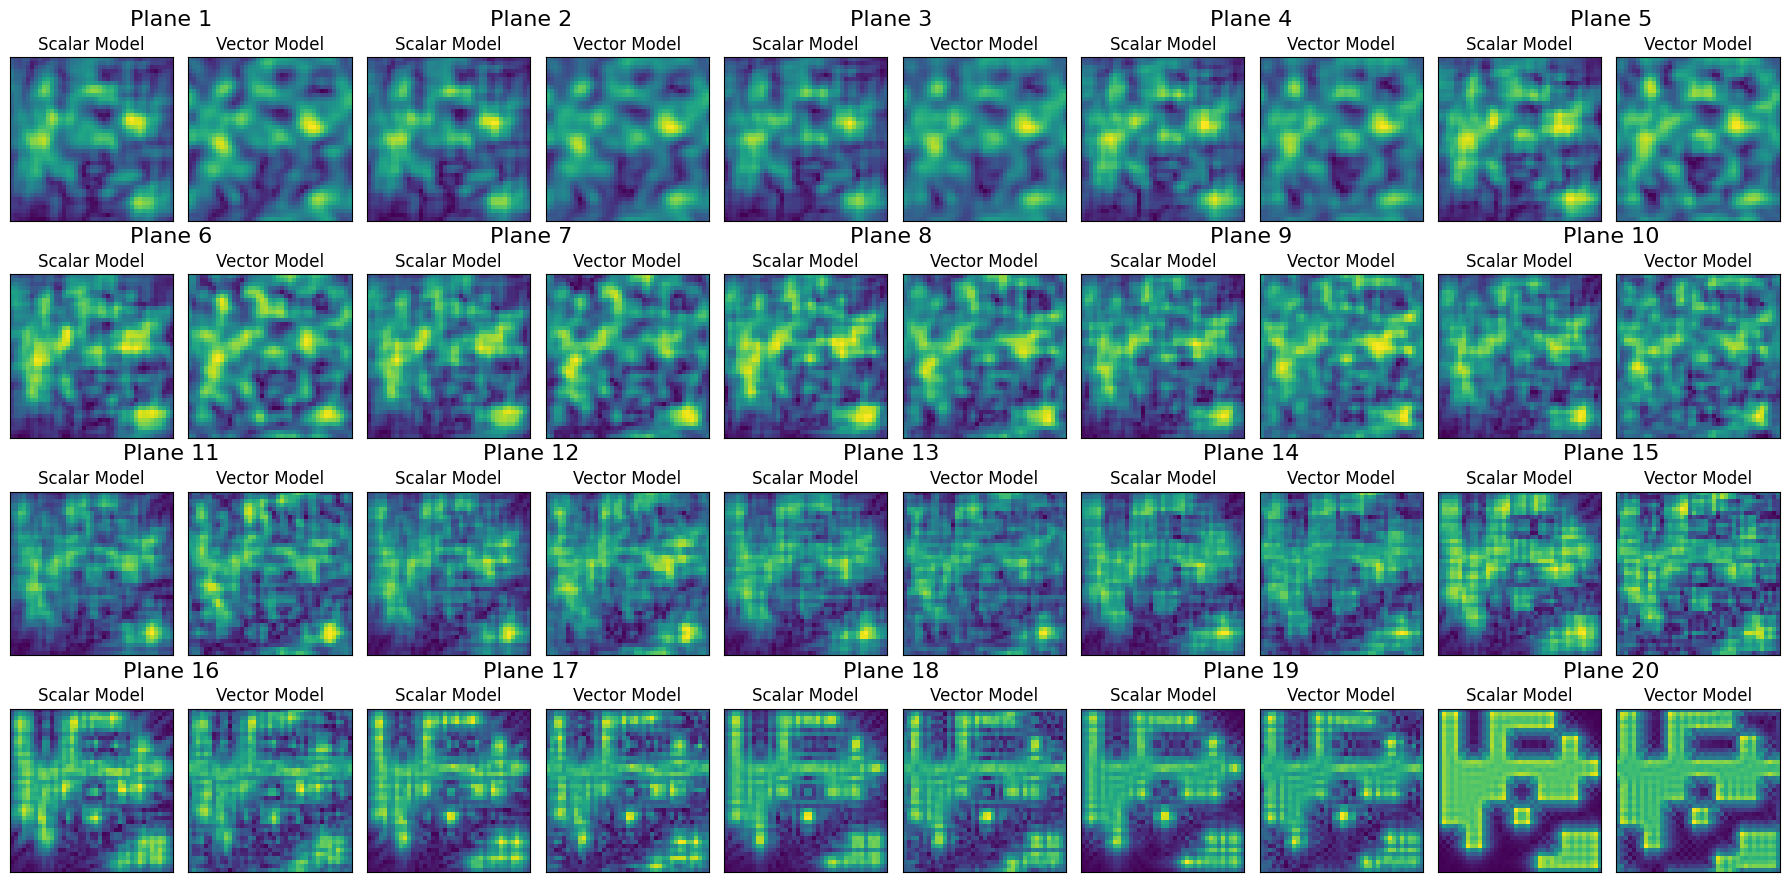

In [7]:
# Parameter Definition
NA = .8
Rindex= 1
lambda_= 532.0/ 1000 #um
dx,dy, dz= 1/3,1/3, 1. #um
ep_dx, ep_dy = 2,2  #um
Nx,Ny,Nz = 41,41,41

# Basic Initializations
fm.init_parameters(NA_ = NA, Rindex_= Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD(ep_dx_=ep_dx, ep_dy_=ep_dy)
aNs = AS.d2nnASwWindow_layer(Nx, Ny, dx, dy, dz, lambda_,window_size=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Field Via Debye Theory
ht_3D = torch.zeros(1, Nz, Nx, Ny).float().to(device)
ht_3D[:, Nz // 2] = fm.ht_2D
debye_result = fm.conv_3D(fm.exPSF_3D, ht_3D).sum(dim=0).to('cpu').detach()

# Field Via Angular Spectrum Method
as_result = torch.zeros(Nz, Nx,Ny, dtype=torch.complex64)
mask_factor = 1/1.5

for i in range(-Nz//2, Nz//2+1):
    aNs.find_transfer_function(dz*i,mask_factor_=mask_factor)
    output_field = aNs.forward(fm.ht_2D.unsqueeze(0))
    field = (output_field.abs()).detach()
    as_result[i+Nz//2] = field

# Visualization Part
vs.visual_3Dcomparision([as_result, debye_result], n_comparision = 2, Nz = 20, n_rows=4, titles=[r"Scalar Model",r"Vector Model"], fig_size=(18,9))

***Multiscale-SSIM to Preserve the Structural Behaviour***

$$\|H_0(x,y,z)\|\quad \xrightarrow{\texttt{Down-Sample}}\quad H_1(x,y,z)$$

Sucessfully Initialized Point Spread Function...!!!


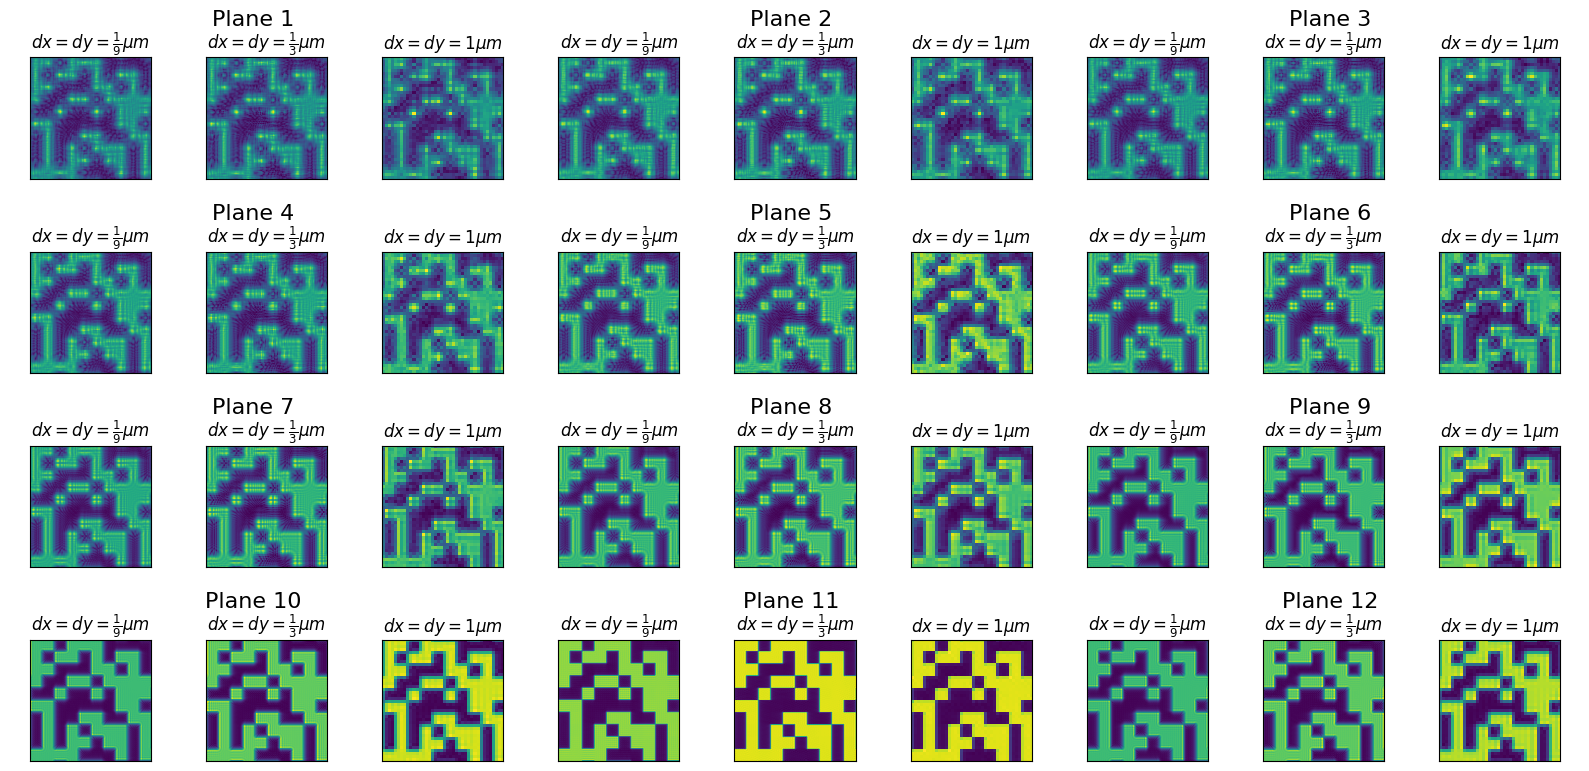

In [2]:
# Parameter Definition
NA = .8
Rindex= 1
lambda_= 532.0/ 1000 #um
dx,dy, dz= 1/9,1/9, 1 #um
ep_dx, ep_dy = 4,4  #um
Nx,Ny,Nz = 360,360, 21
device = 'cpu'

# Basic Initializations
fm.init_parameters(NA_ = NA, Rindex_= Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz,device_=device)
fm.init_DMD(ep_dx_=ep_dx, ep_dy_=ep_dy)

# Formation of Illumination Patterns
ht_3D = torch.zeros(1, Nz, Nx, Ny).float().to(device)
ht_3D[:, Nz // 2] = fm.ht_2D
H0 = fm.conv_3D(fm.exPSF_3D, ht_3D).sum(dim=0).to('cpu')

# Downsampling: Mimic using big dx, dy
def downsample_pattern(H, down_factor = 1/3):
    step_size = round(1/down_factor)
    return H[ :, 0:Nx:step_size,0:Ny:step_size]
    
H1 = downsample_pattern(H0, down_factor=1/3)
H2 = downsample_pattern(H0, down_factor=1/9)


vs.visual_3Dcomparision([H0, H1, H2], n_comparision = 3, Nz = 12, n_rows=4, titles=[r"$dx=dy=\frac{1}{9}\mu m$",r"$dx=dy=\frac{1}{3}\mu m$",r"$dx=dy=1\mu m$"], fig_size=(16,8))

***Multiscale SSIM***

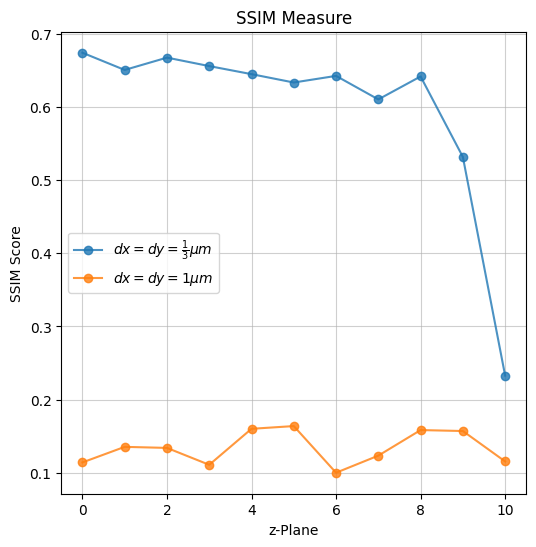

In [6]:
H1_matched = H1.repeat_interleave(3, dim=1).repeat_interleave(3, dim=2)
H2_matched = H2.repeat_interleave(9, dim=1).repeat_interleave(9, dim=2)

SSIM_H1 = []
SSIM_H2 = []

for plane in range(Nz//2+1):
    SSIM_s1 = ssim(H1_matched[plane].abs().numpy(),H0[plane].abs().numpy(), data_range=1e-3)
    SSIM_s2 = ssim(H2_matched[plane].abs().numpy(),H0[plane].abs().numpy(), data_range=1e-3)
    SSIM_H1.append(SSIM_s1), SSIM_H2.append(SSIM_s2)

vs.visualize_SSIM([SSIM_H1, SSIM_H2], labels=[r"$dx=dy=\frac{1}{3}\mu m$",r"$dx=dy=1\mu m$"], set_legend=True, x_label="z-Plane")